# Washington, D.C. Livability Index

## Prompt

For the first part of this exercise, we'd like you to create a livability index for Washington DC. You are welcome to include additional data inputs beyond those listed below. The definition of what livability means is up to you to decide, but you should explain and defend your definition.

The specific combination of datasets and methodology used to create the index is also up to you.

Write up a short document (a google doc, .ipynb or R markdown file) in which you define and discuss your liveability metric and definition. Why is your metric a good one? How is it limited/where may it fall short?
Feel free to include any plots or additional material that help us understand your work. Alongside the write-up please include your code.

## Overview

![alt text](dc_livability-01.png "DC Livability")

**What is Livability?**

"Livability" is a term that is typically used to refer to the quality of life in an area. Livability indexes are often designed to help individuals and families decide on locations to live, such as [AARP's Livability Index](https://livabilityindex.aarp.org/) and [AreaVibes.com](https://www.areavibes.com/about/). Because quality of life can be described by a variety of factors, livability indexes can vary depending on the use case for the index and the audience. 

The livability index produced by the analysis below ranks areas based on six categories that have been shown to affect quality of life. This list is not comprehensive, but is a first draft of an index that can be built upon and refined through additional research and analysis. 

**Livability Categories**
1. **Transportation:** Areas are scored based on access to, and frequency of, public transportation. Access to bikeshare is also included in the score.

2. **Safety:** The safety score is informed by crime data. The more crimes, the lower the safety score.

3. **Health & Environment:** Areas are scored based on their walkability (how much pedestrian infrastructure there is in an area) and the amount of green space.

4. **Affordability:** Affordability is informed by median home values and access to SNAP retail locations. 

5. **Amenities:** Areas are scored based on access to amenities, including grocery stores and social environments where drinking is permitted (liquor licenses).

6. **Access:** Access is defined by the number of jobs within a 45 minute drive or transit trip.

**About the Analysis**

The analysis below calculates a Livability Index for every Census Block Group in Washington, D.C., using publicly available datasets. The analysis was conducted using PostgreSQL, PostGIS, Python, and QGIS. Each input dataset was rescaled such that all values within a variable or an individual index range from 0 to 1, with feature quantities expressed as densities. The final livability score is an average of the individual scores. The final dataset is included in this package. 

**Strengths of the Livability Index**

Rescaling the datasets to a consistent range of values allows the individual scores and their components to be combined and compared. Census Block Group geographies facilitate easy linkages with many publicly available datasets and are small enough to describe an area (typically several blocks) without overgeneralizing. The use of SQL with PostGIS lends itself to efficient processing of data, spatial aggregations, and scoring that can be easily refreshed and updated with new datasets. Grouping the inputs into themes makes it possible to review the degree to which each component contributes to overall livability as defined by the index.

**Limitations of the Livability Index**

The use Census Block Groups creates arbitrary divisions between locations. Another approach would be to create index surfaces using a cell-based approach with adjustable aggregation scales. Because all of the scores use data for the DC area only, scores cannot be compared with other areas. This also may result in counterintuitive scores. For example, areas with some level of crime may show up as very high in the range of safety scores if they have relatively few crimes compared with other areas. Future analysis should incorporate reasonableness checks and thresholds. It should also calculate scores based on regional and national benchmarks. For instance, an area within D.C. (one of the most expensive cities in the US) categorized as "affordable" by this analysis may be outside of the price range of many individuals and families. Because livability is subjective to a degree, future analysis should also incorporate user-defined weights for each category. 

**Additional Notes**

Multiple datasets not listed in the prompt are used in the analysis, including the EPA Smart Location Database, the American Community Survey, Capitol Bikeshare data, D.C. crime data, and USDA SNAP retail locations. Crime data was used in place of 311 calls for the safety score, as 311 calls can be [highly](https://www.bloomberg.com/news/articles/2018-10-18/in-new-york-city-gentrification-brings-more-311-calls) [biased](https://www.governing.com/topics/mgmt/gov-311-data.html). Parks were removed as there was some redundancy with the tree cover and density layers. The tree cover raster was converted to vector using QGIS.

## Import Libraries

In [6]:
from census import Census
from us import states
import pandas as pd 
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook

In [7]:
engine = create_engine('postgresql://amy@localhost:5432/amy')
c = Census("be588bd861cbf7e0545af372027fc4980855f07e")

## Data

### Census

In [8]:
# Table B25077: Median Value (Dollars)
# https://censusreporter.org/topics/housing/

housing = pd.DataFrame.from_dict(c.acs5.get(('NAME', 'group(B25077)'),
          {'for': 'tract:*',
           'in': 'state:{} county:001'.format(states.DC.fips)}))

In [9]:
housing.head()

,NAME,GEO_ID,B25077_001E,B25077_001M,B25077_001EA,B25077_001MA,state,county,tract
0,"Census Tract 99.02, District of Columbia, Dist...",1400000US11001009902,262900.0,15055.0,None,None,11,001,009902
1,"Census Tract 99.04, District of Columbia, Dist...",1400000US11001009904,286700.0,55004.0,None,None,11,001,009904
2,"Census Tract 1, District of Columbia, District...",1400000US11001000100,1333300.0,300601.0,None,None,11,001,000100
3,"Census Tract 8.01, District of Columbia, Distr...",1400000US11001000801,781700.0,101946.0,None,None,11,001,000801
4,"Census Tract 8.02, District of Columbia, Distr...",1400000US11001000802,935400.0,67748.0,None,None,11,001,000802


In [10]:
housing.to_sql('dc_median_housing_acs', con=engine, if_exists='replace')

### SNAP

In [11]:
query = """
    DROP TABLE IF EXISTS dc_snap;
    CREATE TABLE dc_snap AS (
        SELECT address 
        , address_line__2 
        , city 
        , county 
        , store_name 
        , geom 
        FROM snap_locations
        WHERE 1=1 
        AND state = 'DC'
    );
"""

engine.execute(query)

### List of Inputs

In [12]:
bikeshare = 'dc_bikeshare' # https://opendata.dc.gov/datasets/capital-bike-share-locations
bus = 'dc_bus' # https://opendata.dc.gov/datasets/metro-bus-stops
calls = 'dc_311' # https://opendata.dc.gov/datasets/311-city-service-requests-in-2018
crime = 'dc_crime' # https://opendata.dc.gov/datasets/crime-incidents-in-2019
grocery = 'dc_grocery' # https://opendata.dc.gov/datasets/grocery-store-locations
housing = 'dc_median_housing_acs'
liquor = 'dc_liquor' # https://opendata.dc.gov/datasets/liquor-licenses
metro = 'dc_metro' # https://opendata.dc.gov/datasets/54018b7f06b943f2af278bbe415df1de_52
parks = 'dc_parks' # https://opendata.dc.gov/datasets/parks-and-recreation-areas
sidewalks = 'dc_sidewalks' # https://opendata.dc.gov/datasets/sidewalks?geometry=-77.026%2C38.892%2C-77.009%2C38.895
sld = 'dc_sld' # https://www.epa.gov/smartgrowth/smart-location-mapping#SLD
snap = 'dc_snap' # https://www.fns.usda.gov/snap/retailer-locator
trees = 'dc_trees' # https://www.mrlc.gov/viewer/

### Compile Dataset

In [13]:
query = """
    DROP TABLE IF EXISTS dc_livability;
    CREATE TABLE dc_livability AS (
        WITH bikeshare AS (
            SELECT geoid10
            , COUNT(DISTINCT terminal_n) AS num_bikeshare_stations
            FROM dc_bikeshare b 
            JOIN dc_sld sld ON ST_Contains(sld.geom, b.geom)
            WHERE 1=1
            GROUP BY 1
        )
        , bus AS (
            SELECT geoid10
            , COUNT(DISTINCT bstp_geo_i) AS num_bus_stations
            FROM dc_bus bus
            JOIN dc_sld sld ON ST_Contains(sld.geom, bus.geom)
            WHERE 1=1
            GROUP BY 1
        )
        , crime AS (
            SELECT geoid10
            , COUNT(DISTINCT ccn) AS num_crimes
            , COUNT(DISTINCT CASE WHEN LOWER(offense) = 'burglary' THEN ccn END) AS num_crimes_burglary
            , COUNT(DISTINCT CASE WHEN LOWER(offense) = 'robbery' THEN ccn END) AS num_crimes_robbery
            , COUNT(DISTINCT CASE WHEN LOWER(offense) LIKE 'assault%%' THEN ccn END) AS num_crimes_assault
            , COUNT(DISTINCT CASE WHEN LOWER(offense) = 'homicide' THEN ccn END) AS num_crimes_homicide
            , COUNT(DISTINCT CASE WHEN LOWER(offense) LIKE '%%theft%%' THEN ccn END) AS num_crimes_theft
            , COUNT(DISTINCT CASE WHEN LOWER(offense) = 'arson' THEN ccn END) AS num_crimes_arson
            , COUNT(DISTINCT CASE WHEN LOWER(offense) = 'sex_abuse' THEN ccn END) AS num_crimes_sex_abuse
            FROM dc_crime c 
            JOIN dc_sld sld ON ST_Contains(sld.geom, c.geom)
            WHERE 1=1 
            GROUP BY 1
        )
        , grocery AS (
            SELECT geoid10
            , COUNT(DISTINCT gis_id) AS num_grocery_stores
            FROM dc_grocery g 
            JOIN dc_sld sld ON ST_Contains(sld.geom, g.geom)
            WHERE 1=1
            AND present18 = 'Yes'
            GROUP BY 1
        )
        , housing AS (
            SELECT DISTINCT geoid10
            , "B25077_001E" AS median_home_value
            FROM dc_sld sld
            JOIN dc_median_housing_acs h ON h.tract = sld.trfips
            WHERE 1=1
            AND "B25077_001E" > 0
        )
        , liquor AS (
            SELECT DISTINCT geoid10
            , COUNT(DISTINCT license) AS num_liquor_licenses
            , COUNT(DISTINCT CASE WHEN type IN ('Club','Night Club','Tavern','Restaurant') THEN license END) AS num_liquor_licenses_bar_restaurant
            FROM dc_liquor l 
            JOIN dc_sld sld ON ST_Contains(sld.geom, l.geom)
            WHERE 1=1
            AND status = 'Active'
            GROUP BY 1
        )
        , metro AS (
            SELECT geoid10
            , COUNT(DISTINCT gis_id) AS num_metro_stations
            FROM dc_metro m
            JOIN dc_sld sld ON ST_Contains(sld.geom, m.geom)
            WHERE 1=1
            GROUP BY 1
        )
        , parks AS (
            SELECT geoid10
            , SUM(p.shape_area) AS park_area
            FROM dc_parks p
            JOIN dc_sld sld ON ST_Intersects(sld.geom, p.geom)
            WHERE 1=1
            GROUP BY 1
        )
        , sidewalks AS (
            SELECT geoid10
            , SUM(s.shape_area) AS sidewalk_area
            FROM dc_sidewalks s 
            JOIN dc_sld sld ON ST_Intersects(sld.geom, s.geom)
            WHERE 1=1 
            GROUP BY 1
        )
        , snap AS (
            SELECT geoid10
            , COUNT(DISTINCT address || store_name) AS num_snap_retail
            FROM dc_snap sn
            JOIN dc_sld sld ON ST_Contains(sld.geom, sn.geom)
            WHERE 1=1
            GROUP BY 1
        )
        , trees AS (
            SELECT geoid10
            , AVG(dn) AS avg_tree_density
            , COUNT(DISTINCT CASE WHEN dn > 0 THEN tr.id END)*30 AS tree_cover_area
            FROM dc_trees tr
            JOIN dc_sld sld ON ST_Intersects(sld.geom, tr.geom)
            WHERE 1=1
            GROUP BY 1
        )
        
        SELECT sld.geoid10
        , sld.geom
        , sld.ac_land AS land_area
        , sld.d1b AS pop_density
        , sld.d2a_ephhm AS job_pop_mix
        
        -- Transportation
        , COALESCE(num_bikeshare_stations,0) AS num_bikeshare_stations
        , COALESCE(num_bus_stations, 0) AS num_bus_stations
        , COALESCE(num_metro_stations, 0) AS num_metro_stations
        , d4d AS transit_freq
        
        -- Safety
        , COALESCE(num_crimes, 0) AS num_crimes
        , COALESCE(num_crimes_burglary, 0) AS num_crimes_burglary
        , COALESCE(num_crimes_robbery, 0) AS num_crimes_robbery
        , COALESCE(num_crimes_assault, 0) AS num_crimes_assault
        , COALESCE(num_crimes_homicide, 0) AS num_crimes_homicide
        , COALESCE(num_crimes_theft, 0) AS num_crimes_theft
        , COALESCE(num_crimes_arson, 0) AS num_crimes_arson
        , COALESCE(num_crimes_sex_abuse, 0) AS num_crimes_sex_abuse
        
        -- Health & Environment
        , COALESCE(park_area, 0) AS park_area
        , COALESCE(sidewalk_area, 0) AS sidewalk_area
        , COALESCE(tree_cover_area, 0) AS tree_cover_area
        , COALESCE(avg_tree_density, 0) AS avg_tree_density
        
        -- Affordability
        , median_home_value
        , COALESCE(num_snap_retail,0) AS num_snap_retail
        
        -- Amenities
        , COALESCE(num_grocery_stores,0) AS num_grocery_stores
        , COALESCE(num_liquor_licenses,0) AS num_liquor_licenses
        , COALESCE(num_liquor_licenses_bar_restaurant,0) AS num_liquor_licenses_bar_restaurant
        
        -- Access
        , d5ar jobs_45_min_drive
        , d5br jobs_45_min_transit
        
        FROM dc_sld sld 
        LEFT JOIN bikeshare bike ON bike.geoid10 = sld.geoid10
        LEFT JOIN bus ON bus.geoid10 = sld.geoid10
        LEFT JOIN crime c ON c.geoid10 = sld.geoid10
        LEFT JOIN grocery g ON g.geoid10 = sld.geoid10
        LEFT JOIN housing h ON h.geoid10 = sld.geoid10
        LEFT JOIN liquor l ON l.geoid10 = sld.geoid10
        LEFT JOIN metro m ON m.geoid10 = sld.geoid10
        LEFT JOIN parks p ON p.geoid10 = sld.geoid10
        LEFT JOIN sidewalks s ON s.geoid10 = sld.geoid10
        LEFT JOIN snap sn ON sn.geoid10 = sld.geoid10
        LEFT JOIN trees t ON t.geoid10 = sld.geoid10
        
        WHERE 1=1
    );
"""

engine.execute(query)

## Individual Scores

### Transportation

In [14]:
# Add Density Columns

query = """
    ALTER TABLE dc_livability ADD COLUMN bikeshare_density FLOAT;
    ALTER TABLE dc_livability ADD COLUMN bus_density FLOAT;
    ALTER TABLE dc_livability ADD COLUMN metro_density FLOAT;
    UPDATE dc_livability 
    SET bikeshare_density = num_bikeshare_stations::FLOAT/land_area
    , bus_density = num_bus_stations::FLOAT/land_area
    , metro_density = num_metro_stations::FLOAT/land_area
    ; 
"""

engine.execute(query)

In [15]:
# Add Percentiles

query = """
    ALTER TABLE dc_livability ADD COLUMN bikeshare_ntile FLOAT;
    ALTER TABLE dc_livability ADD COLUMN bus_ntile FLOAT;
    ALTER TABLE dc_livability ADD COLUMN metro_ntile FLOAT;
    ALTER TABLE dc_livability ADD COLUMN transit_freq_ntile FLOAT;
    WITH percentiles AS (
        SELECT geoid10
        , PERCENT_RANK() OVER (ORDER BY bikeshare_density) AS bikeshare_ntile
        , PERCENT_RANK() OVER (ORDER BY bus_density) AS bus_ntile
        , PERCENT_RANK() OVER (ORDER BY metro_density) AS metro_ntile
        , PERCENT_RANK() OVER (ORDER BY transit_freq) AS transit_freq_ntile
        FROM dc_livability
        WHERE 1=1
    )
    UPDATE dc_livability AS l
    SET bikeshare_ntile = p.bikeshare_ntile
    , bus_ntile = p.bus_ntile
    , metro_ntile = p.metro_ntile
    , transit_freq_ntile = p.transit_freq_ntile
    FROM percentiles p 
    WHERE 1=1
    AND p.geoid10 = l.geoid10
    ;
"""

engine.execute(query)

In [16]:
# Score

query = """
    ALTER TABLE dc_livability ADD COLUMN transit_score FLOAT;
    UPDATE dc_livability 
    SET transit_score = (bikeshare_ntile + bus_ntile + metro_ntile + transit_freq_ntile)/4
    ;
"""

engine.execute(query)

### Safety

In [17]:
# Add Density Column

query = """
    ALTER TABLE dc_livability ADD COLUMN crime_density FLOAT;
    UPDATE dc_livability 
    SET crime_density = num_crimes::FLOAT/land_area
    ; 
"""

engine.execute(query)

In [18]:
# Add Score

query = """
    ALTER TABLE dc_livability ADD COLUMN crime_score FLOAT;
    WITH percentiles AS (
        SELECT geoid10
        , PERCENT_RANK() OVER (ORDER BY crime_density DESC) AS crime_score
        FROM dc_livability
        WHERE 1=1
    )
    UPDATE dc_livability AS l
    SET crime_score = p.crime_score
    FROM percentiles p 
    WHERE 1=1
    AND p.geoid10 = l.geoid10
    ;
"""

engine.execute(query)

### Health & Environment

In [19]:
# Add Density Columns

query = """
    ALTER TABLE dc_livability ADD COLUMN tree_area_density FLOAT;
    UPDATE dc_livability 
    SET tree_area_density = tree_cover_area::FLOAT/land_area
    ; 
"""

engine.execute(query)

In [20]:
# Add Percentiles

query = """
    ALTER TABLE dc_livability ADD COLUMN park_ntile FLOAT;
    ALTER TABLE dc_livability ADD COLUMN sidewalk_ntile FLOAT;
    ALTER TABLE dc_livability ADD COLUMN tree_area_ntile FLOAT;
    ALTER TABLE dc_livability ADD COLUMN tree_density_ntile FLOAT;
    WITH percentiles AS (
        SELECT geoid10
        , PERCENT_RANK() OVER (ORDER BY park_area) AS park_ntile
        , PERCENT_RANK() OVER (ORDER BY sidewalk_area) AS sidewalk_ntile
        , PERCENT_RANK() OVER (ORDER BY tree_area_density) AS tree_area_ntile
        , PERCENT_RANK() OVER (ORDER BY avg_tree_density) AS tree_density_ntile
        FROM dc_livability
        WHERE 1=1
    )
    UPDATE dc_livability AS l
    SET park_ntile = p.park_ntile
    , sidewalk_ntile = p.sidewalk_ntile
    , tree_area_ntile = p.tree_area_ntile
    , tree_density_ntile = p.tree_density_ntile
    FROM percentiles p 
    WHERE 1=1
    AND p.geoid10 = l.geoid10
    ;
"""

engine.execute(query)

In [21]:
# Score

query = """
    ALTER TABLE dc_livability DROP COLUMN IF EXISTS env_score;
    ALTER TABLE dc_livability ADD COLUMN env_score FLOAT;
    UPDATE dc_livability 
    SET env_score = (sidewalk_ntile + tree_area_ntile + tree_density_ntile)/3
    ;
"""

engine.execute(query)

### Affordability

In [22]:
# Add Percentiles

query = """
    ALTER TABLE dc_livability ADD COLUMN home_value_ntile FLOAT;
    ALTER TABLE dc_livability ADD COLUMN snap_ntile FLOAT;
    WITH percentiles AS (
        SELECT geoid10
        , PERCENT_RANK() OVER (ORDER BY median_home_value DESC) AS home_value_ntile
        , PERCENT_RANK() OVER (ORDER BY num_snap_retail) AS snap_ntile
        FROM dc_livability
        WHERE 1=1
    )
    UPDATE dc_livability AS l
    SET home_value_ntile = p.home_value_ntile
    , snap_ntile = p.snap_ntile
    FROM percentiles p 
    WHERE 1=1
    AND p.geoid10 = l.geoid10
    ;
"""

engine.execute(query)

In [23]:
# Score

query = """
    ALTER TABLE dc_livability ADD COLUMN aff_score FLOAT;
    UPDATE dc_livability 
    SET aff_score = (home_value_ntile + snap_ntile)/2
    ;
"""

engine.execute(query)

### Amenities

In [24]:
# Add Density Columns

query = """
    ALTER TABLE dc_livability ADD COLUMN grocery_density FLOAT;
    ALTER TABLE dc_livability ADD COLUMN liquor_density FLOAT;
    UPDATE dc_livability 
    SET grocery_density = num_grocery_stores::FLOAT/land_area
    , liquor_density = num_liquor_licenses_bar_restaurant::FLOAT/land_area
    ; 
"""

engine.execute(query)

In [25]:
# Add Percentiles

query = """
    ALTER TABLE dc_livability ADD COLUMN grocery_ntile FLOAT;
    ALTER TABLE dc_livability ADD COLUMN liquor_ntile FLOAT;
    WITH percentiles AS (
        SELECT geoid10
        , PERCENT_RANK() OVER (ORDER BY grocery_density) AS grocery_ntile
        , PERCENT_RANK() OVER (ORDER BY liquor_density) AS liquor_ntile
        FROM dc_livability
        WHERE 1=1
    )
    UPDATE dc_livability AS l
    SET grocery_ntile = p.grocery_ntile
    , liquor_ntile = p.liquor_ntile
    FROM percentiles p 
    WHERE 1=1
    AND p.geoid10 = l.geoid10
    ;
"""

engine.execute(query)

In [26]:
# Score

query = """
    ALTER TABLE dc_livability ADD COLUMN amenity_score FLOAT;
    UPDATE dc_livability 
    SET amenity_score = (grocery_ntile + liquor_ntile)/2
    ;
"""

engine.execute(query)

### Access

In [27]:
# Add Percentiles

query = """
    ALTER TABLE dc_livability ADD COLUMN jobs_drive_ntile FLOAT;
    ALTER TABLE dc_livability ADD COLUMN jobs_transit_ntile FLOAT;
    WITH percentiles AS (
        SELECT geoid10
        , PERCENT_RANK() OVER (ORDER BY jobs_45_min_drive) AS jobs_drive_ntile
        , PERCENT_RANK() OVER (ORDER BY jobs_45_min_transit) AS jobs_transit_ntile
        FROM dc_livability
        WHERE 1=1
    )
    UPDATE dc_livability AS l
    SET jobs_drive_ntile = p.jobs_drive_ntile
    , jobs_transit_ntile = p.jobs_transit_ntile
    FROM percentiles p 
    WHERE 1=1
    AND p.geoid10 = l.geoid10
    ;
"""

engine.execute(query)

In [28]:
# Score

query = """
    ALTER TABLE dc_livability ADD COLUMN access_score FLOAT;
    UPDATE dc_livability 
    SET access_score = (jobs_drive_ntile + jobs_transit_ntile)/2
    ;
"""

engine.execute(query)

## Index

In [29]:
query = """
    ALTER TABLE dc_livability DROP COLUMN IF EXISTS livability_score;
    ALTER TABLE dc_livability ADD COLUMN livability_score FLOAT;
    UPDATE dc_livability
    SET livability_score = (transit_score + crime_score + env_score + aff_score + amenity_score + access_score)::FLOAT/6
    ;
"""

engine.execute(query)

## Map

In [30]:
query = """
    WITH dump AS (
        SELECT DISTINCT geoid10
        , (ST_Dump(geom)).geom AS geom
        , livability_score
        FROM dc_livability
    )
    SELECT geoid10
    , ST_AsText(geom) AS geom
    , livability_score
    FROM dump;
"""

map_data = pd.read_sql_query(query, con=engine)

In [31]:
map_data.head()

,geoid10,geom,livability_score
0,110010001001,"POLYGON((-77.0649741669999 38.9190317750001,-7...",0.653582
1,110010001002,"POLYGON((-77.051140161 38.9106177740001,-77.05...",0.524468
2,110010001003,"POLYGON((-77.060624164 38.9076527730001,-77.06...",0.545781
3,110010001004,"POLYGON((-77.057075163 38.907699773,-77.057072...",0.504640
4,110010002011,"POLYGON((-77.074119169 38.912592773,-77.073940...",0.457993


In [32]:
map_data['geom'] = map_data['geom'].apply(wkt.loads)

In [33]:
map_geo = gpd.GeoDataFrame(map_data, geometry = 'geom')

<IPython.core.display.Javascript object>


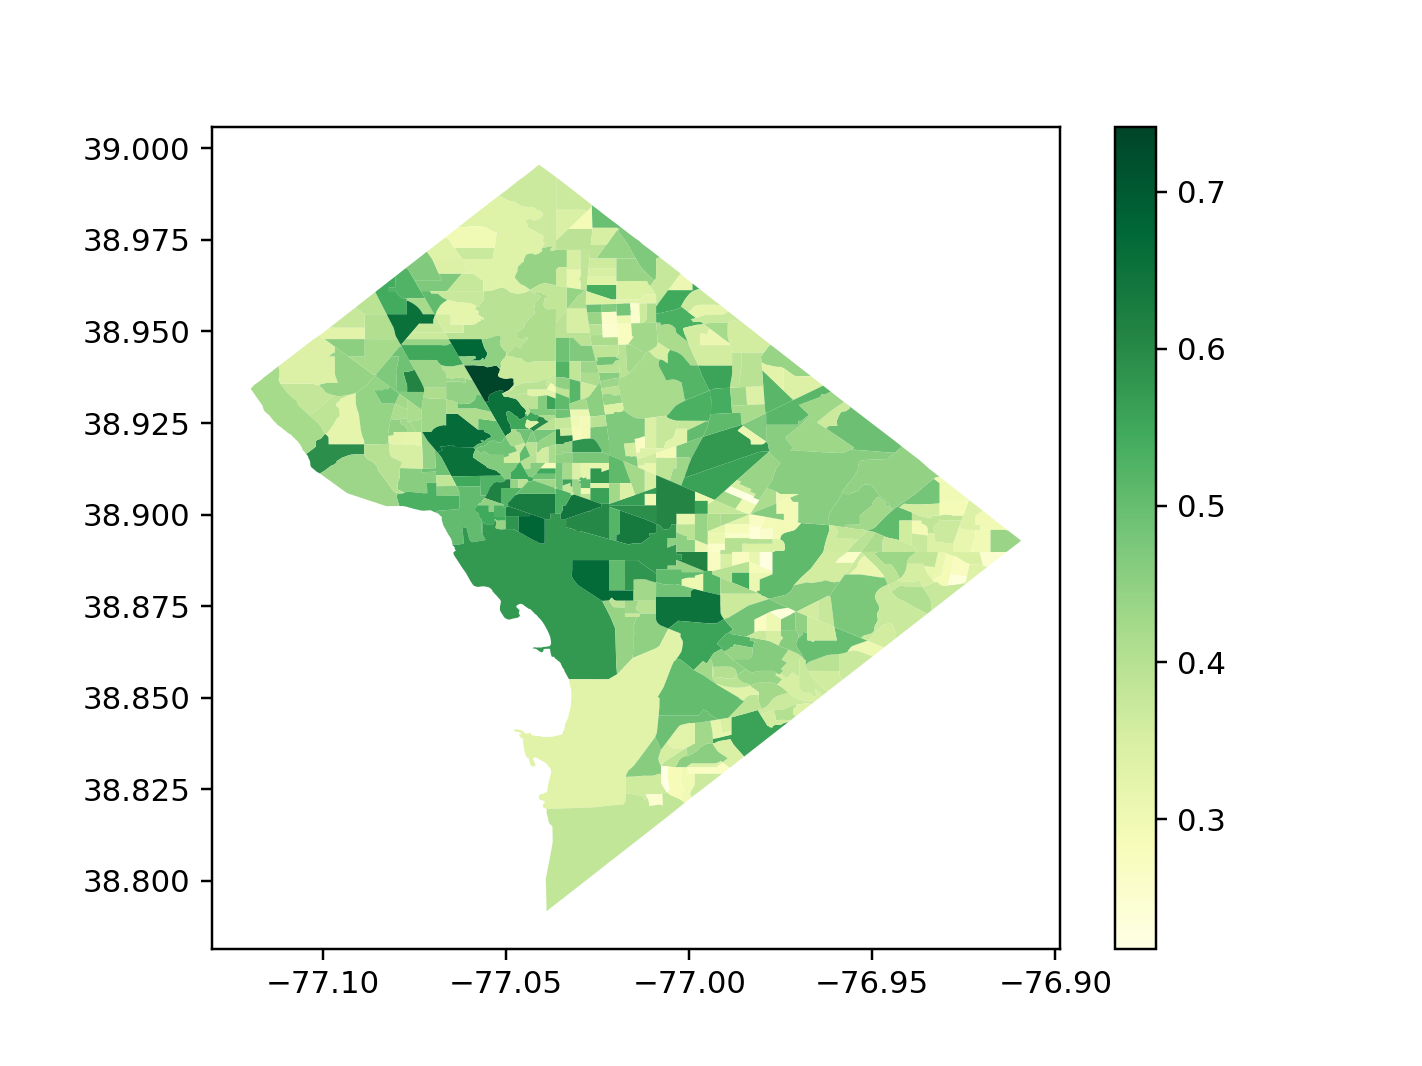

In [35]:
map_geo.plot(column='livability_score', legend=True, cmap='YlGn')

plt.show()

### Highest / Lowest Areas

**Highest Score**

![alt text](livability_highest.png "DC Livability")

**Lowest Score**

![alt text](livability_lowest.png "DC Livability")

# Data Conception: Los Angeles Skyline

## Prompt

A major real estate website wants to know which of their property listings have a view of the Los Angeles skyline.
How would you build a dataset to address this need? Walk us through the steps you would take:

- What data do you need? (Broadly)
- What does your process look like?
- What would be needed to scale the dataset beyond Los Angeles?
- What are the biggest challenges of creating this dataset?

## Data Needs

- Building footprints including height and elevation ([example](https://geohub.lacity.org/datasets/813fcefde1f64b209103107b26a8909f_0?geometry=-118.259%2C34.053%2C-118.231%2C34.060))
- If the real-estate company has a specific area in mind for what they would consider the "Los Angeles skyline", a shape defining that area
- For each of the real-estate company's properties, the height, elevation, number of floors, and which directions windows face

## Process

For each floor and view direction:
1. Create a straight line starting at the "observation point" (elevation) and traveling through the top vertices of each of the buildings in the directions for which there are windows facing outward. We'll call these "sight lines".
2. For each sight line, count the number of unique buildings it passes through. A simple rule is that if the lines passing through one building all pass through at least one additional building, it is not part of the skyline (where the building top and sky "touch" from the perspective of the viewer).
3. Calculate the total number of buildings in the skyline from the perspective of the viewer. If there are zero buildings, it does not have a skyline view. If there are buildings in the skyline, apply a measure of magnitude (this perspective has an X% view of the skyline, etc).
4. Create a building level skyline score based on overall visibility.

## Scaling the Analysis

In order to scale this analysis to other cities, 3D building footprints and information about properties will be needed. In mountainous areas, a DEM may also be needed to estimate terrain visibility and/or places where terrain may obstruct the view of the built environment.

## Challenges

While more and more data is being published by public agencies and the [open source community](https://osmbuildings.org/documentation/viewer/), data availability and quality information (accuracy, how current it is, etc) is an anticipated challenge. The analysis described would also rely on accurate and detailed data about properties. Without this information, best estimates will need to be made based on best available footprint information.